In [2]:
# Setup for local environment
import sys
import os

# Add the current directory to Python path
sys.path.append('.')

# Download CIFAR-10 dataset if it doesn't exist
import subprocess
import os

# Check if dataset exists, if not download it
cifar_dir = 'cs231n/datasets/cifar-10-batches-py'
if not os.path.exists(cifar_dir):
    print("Downloading CIFAR-10 dataset...")
    os.chdir('cs231n/datasets')
    subprocess.run(['bash', 'get_datasets.sh'], shell=True)
    os.chdir('../..')
    print("Dataset download complete!")
else:
    print("CIFAR-10 dataset already exists.")

CIFAR-10 dataset already exists.


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
regularization_strengths = [1e4, 1e5, 5e5, 1e6, 5e6, 1e7]

results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################
# Hyperparameter tuning
for lr in learning_rates:
    for reg in regularization_strengths:
        # Create and train softmax classifier
        softmax = Softmax()
        softmax.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        # Predict on training and validation sets
        y_train_pred = softmax.predict(X_train_feats)
        y_val_pred = softmax.predict(X_val_feats)
        
        # Calculate accuracies
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        # Store results
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        # Update best model
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

c:\Users\user\GithubRepo\25SummerStudy\cs231n\assignment1_colab\cs231n\classifiers\softmax.py:102: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(correct_class_probs))
c:\Users\user\GithubRepo\25SummerStudy\cs231n\assignment1_colab\cs231n\classifiers\softmax.py:103: RuntimeWarning: overflow encountered in scalar multiply
  loss = loss / num_train + reg * np.sum(W * W)
c:\Users\user\.conda\envs\assignment1\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\user\GithubRepo\25SummerStudy\cs231n\assignment1_colab\cs231n\classifiers\softmax.py:103: RuntimeWarning: overflow encountered in multiply
  loss = loss / num_train + reg * np.sum(W * W)
c:\Users\user\GithubRepo\25SummerStudy\cs231n\assignment1_colab\cs231n\classifiers\softmax.py:117: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + 2 * reg * W
c:\Users\user\GithubRepo\25Su

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.090551 val accuracy: 0.091000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.109510 val accuracy: 0.119000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.422796 val accuracy: 0.419000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.424122 val accuracy: 0.420000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.411918 val accuracy: 0.419000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.395306 val accuracy: 0.380000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.109735 val accuracy: 0.128000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.420551 val accuracy: 0.413000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.418265 val accuracy: 0.420000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.400857 val accuracy: 0.395000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.324816 val accuracy: 0.357000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.085000 val accuracy: 0.075000
lr 1.000000e-06 reg 1.000000

In [7]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


In [8]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


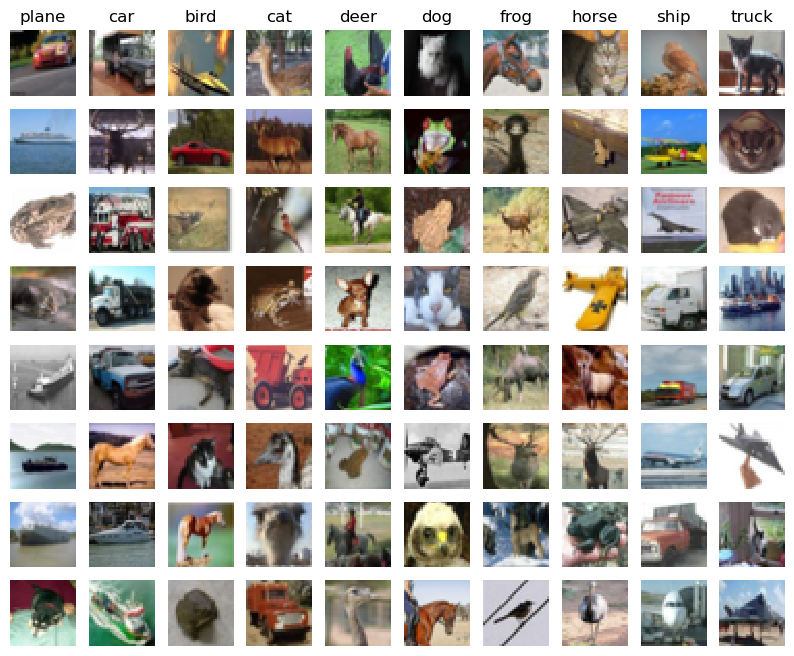

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ *The misclassifications show reasonable confusion between visually similar classes. For example, birds are often misclassified as planes (both have similar shapes and backgrounds), cars as trucks (both vehicles), and cats as dogs (both four-legged animals). This makes sense because HOG features capture shape/texture while color histograms capture color information, but some classes share similar visual characteristics that these features cannot distinguish well.*





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [13]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Hyperparameter tuning for neural network on features
learning_rates = [1e-3, 2e-3, 5e-3, 1e-2]  
hidden_dims = [300, 500, 800]             
regularization_strengths = [1e-5, 1e-4, 1e-3]  

best_val_acc = -1
best_net = None

combo_count = 0
total_combos = len(learning_rates) * len(hidden_dims) * len(regularization_strengths)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for reg in regularization_strengths:
            combo_count += 1
            
            # Create and train model
            net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg)
            solver = Solver(net, data, update_rule='adam',  # sgd → adam
                          optim_config={'learning_rate': lr},
                          lr_decay=0.90, num_epochs=25, batch_size=256,
                          print_every=256, verbose=False)
            solver.train()
            
            # Check validation accuracy
            val_acc = solver.best_val_acc
            print(f"[{combo_count:2d}/{total_combos:2d}] lr={lr}, hidden_dim={hidden_dim}, reg={reg}, val_acc={val_acc:.3f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net

print(f"Best validation accuracy: {best_val_acc:.3f}")

[ 1/36] lr=0.001, hidden_dim=300, reg=1e-05, val_acc=0.611
[ 2/36] lr=0.001, hidden_dim=300, reg=0.0001, val_acc=0.611
[ 3/36] lr=0.001, hidden_dim=300, reg=0.001, val_acc=0.621
[ 4/36] lr=0.001, hidden_dim=500, reg=1e-05, val_acc=0.619
[ 5/36] lr=0.001, hidden_dim=500, reg=0.0001, val_acc=0.614
[ 6/36] lr=0.001, hidden_dim=500, reg=0.001, val_acc=0.629
[ 7/36] lr=0.001, hidden_dim=800, reg=1e-05, val_acc=0.614
[ 8/36] lr=0.001, hidden_dim=800, reg=0.0001, val_acc=0.629
[ 9/36] lr=0.001, hidden_dim=800, reg=0.001, val_acc=0.622
[10/36] lr=0.002, hidden_dim=300, reg=1e-05, val_acc=0.613
[11/36] lr=0.002, hidden_dim=300, reg=0.0001, val_acc=0.611
[12/36] lr=0.002, hidden_dim=300, reg=0.001, val_acc=0.619
[13/36] lr=0.002, hidden_dim=500, reg=1e-05, val_acc=0.608
[14/36] lr=0.002, hidden_dim=500, reg=0.0001, val_acc=0.613
[15/36] lr=0.002, hidden_dim=500, reg=0.001, val_acc=0.638
[16/36] lr=0.002, hidden_dim=800, reg=1e-05, val_acc=0.623
[17/36] lr=0.002, hidden_dim=800, reg=0.0001, val_a

In [14]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.595


In [15]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
